# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.**

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [407]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt

from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline

In [7]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



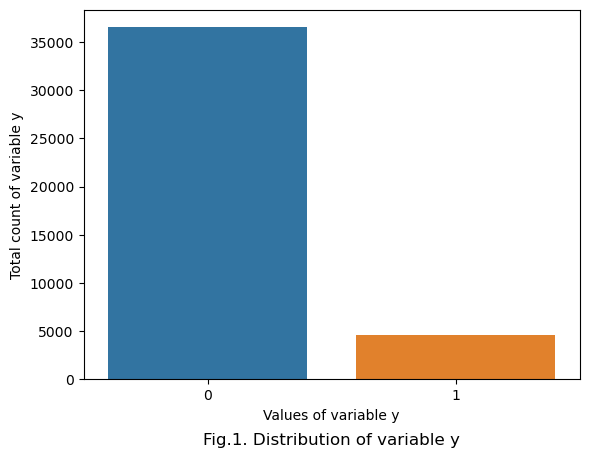

In [422]:
sns.countplot(df, x="y")
plt.ylabel("Total count of variable y")
plt.xlabel("Values of variable y")
plt.title("Fig.1. Distribution of variable y", x=0.5, y=-0.2)
plt.savefig('1.png')
#The dataset is imbalanced

In [9]:
#The data has no missing values
assert df.isna().agg(sum).sum() == 0

In [10]:
#Duplication
df.duplicated().sum()

12

In [12]:
#Dropping duplicates
df = df.drop_duplicates(keep=False)

In [ ]:
#Converting month and day_of_week variables to date type had no singninficant effect on the final result.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

***Business objective is to find a machine learning model that would predict whether a customer would open a long term deposit or not. The model will help improve the efficiency of marketing campaings by adjusting the campaign's parameters according to the model.***

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [13]:
#I will encode the target variable now and everything else afte the train/test split
df['y'] = df['y'].map({'yes': 1, 'no': 0})

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [15]:
X = df.drop(labels=["y"], axis=1)
y = df["y"]

In [21]:
#Using stratify option
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

X_train.shape, X_test.shape

((32931, 20), (8233, 20))

In [23]:
#Enocoding categorical values with target encoder
target_enc = TargetEncoder(cols=None, min_samples_leaf=25, smoothing=1.0)

In [24]:
target_enc.fit(X_train, y_train)

TargetEncoder(cols=['job', 'marital', 'education', 'default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'poutcome'],
              min_samples_leaf=25, smoothing=1.0)

In [26]:
X_train_enc = target_enc.transform(X_train)
X_test_enc = target_enc.transform(X_test)

In [29]:
#Scaling
scaler = StandardScaler()

scaler.fit(X_train_enc)

X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

***The accuracy score is not a good metric for evaluating models built on imbalanced data set. Given the business problem, the precision score seems to be more appropriate. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. In this context it means the customer does not open long term deposit, but the model predicts the opposite. This type of error would impact revenue forcast negatively and everybody hates when it happens.***

In [37]:
#We will use a sklearn dummy classifier to establish a baseline
dummy_clf = DummyClassifier(strategy="prior")

In [289]:
start_time = time.time()
dummy_clf.fit(X_train_scaled, y_train)
end_time = time.time()

In [293]:
training_time = end_time - start_time
round(training_time, 4)

0.004

In [134]:
y_pred_test = dummy_clf.predict(X_test_scaled)

In [135]:
y_pred_train = dummy_clf.predict(X_train_scaled)

In [139]:
#the dummy classifer predicts no instance of 1 class, therefore we can't really calculate false positive rate or 
#precision score
np.unique(y_pred_test)

array([0])

In [140]:
#we can look at the classification report to confirm that
report = classification_report(y_test, y_pred_test, zero_division=0)

In [141]:
print(report)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7305
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8233
   macro avg       0.44      0.50      0.47      8233
weighted avg       0.79      0.89      0.83      8233



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [63]:
log_reg = LogisticRegression()

In [295]:
start_time = time.time()
log_reg.fit(X_train_scaled, y_train)
end_time = time.time()

In [296]:
training_time = end_time - start_time
round(training_time, 4)

0.099

In [297]:
y_pred_test_log = log_reg.predict(X_test_scaled)
y_pred_train_log = log_reg.predict(X_train_scaled)

In [298]:
precision_test_log = precision_score(y_test, y_pred_test_log)
precision_train_log = precision_score(y_train, y_pred_train_log)

### Problem 9: Score the Model

What is the accuracy of your model?

In [299]:
print("Test set precision score: ", round(precision_test_log, 3))
print("Train set precision score: ", round(precision_train_log, 3))

Test set precision score:  0.667
Train set precision score:  0.664


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

**KNN**

In [300]:
knn = KNeighborsClassifier()

In [301]:
start_time = time.time()
knn.fit(X_train_scaled, y_train)
end_time = time.time()

In [302]:
training_time = end_time - start_time
round(training_time, 4)

0.0151

In [303]:
y_pred_test_knn = knn.predict(X_test_scaled)
y_pred_train_knn = knn.predict(X_train_scaled)

In [304]:
precision_test_knn = precision_score(y_test, y_pred_test_knn)
precision_train_knn = precision_score(y_train, y_pred_train_knn)

In [305]:
print("Test set precision score: ", round(precision_test_knn, 3))
print("Train set precision score: ", round(precision_train_knn, 3))

Test set precision score:  0.575
Train set precision score:  0.745


**Decision tree**

In [306]:
decision_tree = DecisionTreeClassifier()

In [307]:
start_time = time.time()
decision_tree.fit(X_train_scaled, y_train)
end_time = time.time()

In [308]:
training_time = end_time - start_time
round(training_time, 4)

0.1478

In [309]:
y_pred_test_tree = decision_tree.predict(X_test_scaled)
y_pred_train_tree = decision_tree.predict(X_train_scaled)

In [310]:
precision_test_tree = precision_score(y_test, y_pred_test_tree)
precision_train_tree = precision_score(y_train, y_pred_train_tree)

In [311]:
print("Test set precision score: ", round(precision_test_tree, 3))
print("Train set precision score: ", round(precision_train_tree, 3))

Test set precision score:  0.49
Train set precision score:  1.0


**SVM**

In [312]:
svc = SVC()

In [313]:
start_time = time.time()
svc.fit(X_train_scaled, y_train)
end_time = time.time()

In [314]:
training_time = end_time - start_time
round(training_time, 4)

5.0279

In [316]:
y_pred_test_svc = svc.predict(X_test_scaled)
y_pred_train_svc = svc.predict(X_train_scaled)

In [317]:
precision_test_svc = precision_score(y_test, y_pred_test_svc)
precision_train_svc = precision_score(y_train, y_pred_train_svc)

In [319]:
print("Test set precision score: ", round(precision_test_svc, 3))
print("Train set precision score: ", round(precision_train_svc, 3))

Test set precision score:  0.664
Train set precision score:  0.749


**Model Comparison**

In [353]:
res_dict = {'Model': ['Dummy','Logistic', 'KNN', 'DTree', 'SVM'],
           'Train score': [0, 0.664, 0.745, 1.0, 0.749],
           'Test score': [0, 0.667, 0.575, 0.49, 0.664],
           'Train time (s)': [0.004, 0.099, 0.0151, 0.1478, 5.028]}
results_df = pd.DataFrame(res_dict).set_index('Model')

In [354]:
results_df

,Train score,Test score,Train time (s)
Model,,,
Dummy,0.000,0.000,0.0040
Logistic,0.664,0.667,0.0990
KNN,0.745,0.575,0.0151
DTree,1.000,0.490,0.1478
SVM,0.749,0.664,5.0280


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

**Using GridSearchCV to find the best hyperparameters**

Logistic GridSearch

In [73]:
param_grid_logistic = {
    'C': [0.1, 1, 10, 100],       
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga'] 
}

In [74]:
grid_search_log = GridSearchCV(estimator=log_reg, param_grid=param_grid_logistic, cv=5, scoring='precision')

In [75]:
grid_search_log.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='precision')

In [171]:
best_log = grid_search_log.best_estimator_

In [332]:
y_pred_test_log_g = best_log.predict(X_test_scaled)
y_pred_train_log_g = best_log.predict(X_train_scaled)

In [333]:
precision_test_log_g = precision_score(y_test, y_pred_test_log_g)
precision_train_log_g = precision_score(y_train, y_pred_train_log_g)

In [334]:
print("Test set precision score: ", round(precision_test_log_g, 3))
print("Train set precision score: ", round(precision_train_log_g, 3))

Test set precision score:  0.665
Train set precision score:  0.664


In [174]:
print("Best parameters found: ", grid_search_log.best_params_)

Best parameters found:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


**KNN GridSearch**

In [98]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [99]:
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='precision')

In [100]:
grid_search_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='precision')

In [101]:
best_knn = grid_search_knn.best_estimator_

In [335]:
y_pred_test_knn_g = best_knn.predict(X_test_scaled)
y_pred_train_knn_g = best_knn.predict(X_train_scaled)

In [336]:
precision_test_knn_g = precision_score(y_test, y_pred_test_knn_g)
precision_train_knn_g = precision_score(y_train, y_pred_train_knn_g)

In [109]:
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


In [337]:
print("Test set precision score: ", round(precision_test_knn_g, 3))
print("Train set precision score: ", round(precision_train_knn_g, 3))

Test set precision score:  0.602
Train set precision score:  0.727


**Decision tree GridSearch**

In [115]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [116]:
grid_search_tree = GridSearchCV(estimator=decision_tree, param_grid=param_grid_tree, scoring='precision', cv=5, n_jobs=-1, verbose=2)

In [117]:
grid_search_tree.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='precision', verbose=2)

In [118]:
best_model_tree = grid_search_tree.best_estimator_

In [340]:
y_pred_test_tree_g = best_model_tree.predict(X_test_scaled)
y_pred_train_tree_g = best_model_tree.predict(X_train_scaled)

In [120]:
print("Best parameters found: ", grid_search_tree.best_params_)

Best parameters found:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [341]:
precision_test_tree_g = precision_score(y_test, y_pred_test_tree_g)
precision_train_tree_g = precision_score(y_train, y_pred_train_tree_g)

In [342]:
print("Test set precision score: ", round(precision_test_tree_g, 3))
print("Train set precision score: ", round(precision_train_tree_g, 3))

Test set precision score:  0.593
Train set precision score:  0.732


**SVM GridSearch**

In [126]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],       
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'gamma': ['scale', 'auto']    
}

In [384]:
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=5, scoring='precision')

In [128]:
grid_search_svc.fit(X_train_scaled, y_train)

[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s


[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0

[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='precision')

In [129]:
best_model_svc = grid_search_svc.best_estimator_

In [185]:
y_pred_test_svc_g = best_model_svc.predict(X_test_scaled)
y_pred_train_svc_g = best_model_svc.predict(X_train_scaled)

In [188]:
print("Best parameters found: ", grid_search_svc.best_params_)

Best parameters found:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}


In [189]:
precision_test_svc_g = precision_score(y_test, y_pred_test_svc_g)
precision_train_svc_g = precision_score(y_train, y_pred_train_svc_g)

In [190]:
print("Test set precision score: ", round(precision_test_svc_g, 3))
print("Train set precision score: ", round(precision_train_svc_g, 3))

Test set precision score:  0.691
Train set precision score:  0.764


**Comparing precision scores on test data of the defualt models witht the tuned models**

In [347]:
res_dict2 = {'Model': ['Logistic', 'KNN', 'DTree', 'SVM'],
           'Default': [0.667, 0.575, 0.49, 0.664],
           'Best params': [0.665, 0.602, 0.593, 0.691]}
results_df2 = pd.DataFrame(res_dict2).set_index('Model')

In [348]:
results_df2

,Default,Best params
Model,,
Logistic,0.667,0.665
KNN,0.575,0.602
DTree,0.490,0.593
SVM,0.664,0.691


**Using Sequential Feature Selector to remove (backward selection) features to form a feature subset for SVM**

In [349]:
#Please note that running SFS on SVM takes a lot of time so I did it in parallel on few environments, so the 
#following code represents only one iteration.

In [385]:
#Using the best parameters from the GridSearch earlier
svc2 = SVC(C=0.1, gamma='scale', kernel='poly')

In [386]:
sfs = SequentialFeatureSelector(svc2, n_features_to_select=11, direction='backward', scoring='precision')

In [387]:
pipeline = Pipeline([
    ('feature_selection', sfs),
    ('SVM', svc2)
])

In [388]:
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('feature_selection',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=SVC(C=0.1, kernel='poly'),
                                           n_features_to_select=11,
                                           scoring='precision')),
                ('SVM', SVC(C=0.1, kernel='poly'))])

In [390]:
y_pred_test_svc_2 = pipeline.predict(X_test_scaled)
y_pred_train_svc_2 = pipeline.predict(X_train_scaled)

In [391]:
precision_test_svc_2 = precision_score(y_test, y_pred_test_svc_2)
precision_train_svc_2 = precision_score(y_train, y_pred_train_svc_2)

In [392]:
print("Test set precision score: ", round(precision_test_svc_2, 3))
print("Train set precision score: ", round(precision_train_svc_2, 3))

Test set precision score:  0.714
Train set precision score:  0.758


In [393]:
selected_features = sfs.get_support(indices=True)

In [394]:
print(f'Selected Features: {X.columns[selected_features].tolist()}')

Selected Features: ['job', 'education', 'loan', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.price.idx', 'nr.employed']


In [ ]:
#I put all test and train precision scores for nine iterations in the dataframe. I also ran out of time to iterate
#through all n Features.

In [396]:
res_dict3 = {'n Features': [2, 3, 4, 5, 9, 10, 11, 15, 20],
           'Train score': [0.704, 0.718, 0.722, 0.726, 0.748, 0.754, 0.758, 0.755, 0.764],
           'Test score': [0.65, 0.708, 0.711, 0.699, 0.713, 0.725, 0.714, 0.709, 0.691]}
results_df3 = pd.DataFrame(res_dict3).set_index('n Features')

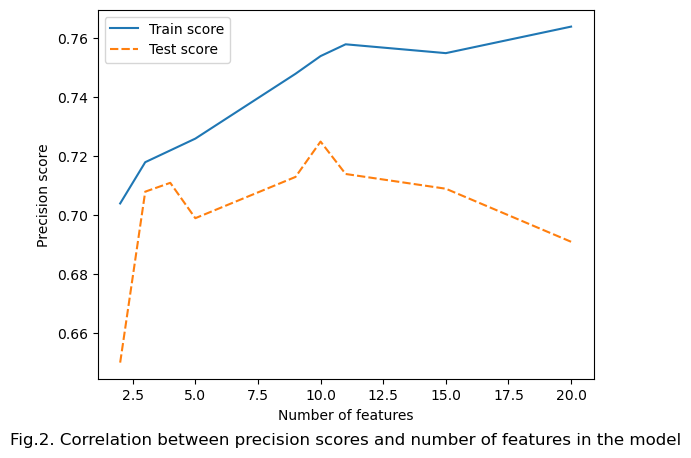

In [423]:
sns.lineplot(data=results_df3)
plt.ylabel("Precision score")
plt.xlabel("Number of features")
plt.title("Fig.2. Correlation between precision scores and number of features in the model", x=0.5, y=-0.2)
plt.savefig('2.png')

**Feature rankings**

For every iteration of SFS I used get_support method to get selected features and counted the total number of instances they were selected.

In [399]:
res_dict4 = {'Feature': ['day_of_week', 'duration', 'campaign', 'poutcome', 'nr.employed', 'job', 'education', 'loan', 'pdays', 'cons.price.idx', 'housing'],
           'Rank': [5, 8, 6, 7, 8, 4, 4, 3, 4, 3, 1]}
results_df4 = pd.DataFrame(res_dict4).set_index('Feature')

In [406]:
results_df4.sort_values(by=['Rank'], ascending=False)

,Rank
Feature,
duration,8
nr.employed,8
poutcome,7
campaign,6
day_of_week,5
job,4
education,4
pdays,4
loan,3


##### Questions